# DeepFX Sentiment Analysis Network

## Package Imports 

In [18]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import pickle


from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.recurrent import LSTM
from keras.preprocessing.text import Tokenizer
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

np.random.seed(10)
%matplotlib inline

## Functions to perform word embeddings 

In [3]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`. 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len), dtype=int)
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [w.lower() for w in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j += 1
                if j >= max_len:
                    break
            
    return X_indices

def cleanSentences(string):
    strip_special_chars = re.compile("[^A-Za-z ]+")
    # remove b"
    string = string.lower().replace("b\"", " ")
    # remove b\'
    string = string.lower().replace("b\'", "")
    return re.sub(strip_special_chars, "", string.lower())

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

def create_dataset(dataset, look_back):
    #dataX, dataY = [], []
    dataX= []
    for i in range(len(dataset)-look_back+1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        #dataY.append(dataset[i + look_back - 1, :])
    #return np.array(dataX), np.array(dataY)
    return np.array(dataX)

## Import cleaned data

In [6]:
#data = pd.read_csv('../input/processed_data.csv')
data = pd.read_csv('/Users/sasi/Documents/cs230_project/deepFX/input/processed_data.csv')
data['Date'] = pd.to_datetime(data.Date)

### Split output data: 80% train, 20% validation

In [7]:
train_split = 0.8
total_count = data.shape[0]
train_cut = int(total_count* train_split)
train = data.loc[: train_cut-1, :]
test = data.loc[train_cut :, :]
y_train = np.array(train["Label"])
y_test = np.array(test["Label"])

In [101]:
# train.head() # Uncomment to view snippet of processed data

In [34]:
#SASI: SAVE ALL DATA FOR ACTIVATIONS
with open('../myDates.p','rb') as f:
    myDates = pickle.load(f)

foo_data = data.set_index('Date')
all_data = foo_data[foo_data.index.isin(myDates)]

finDates = all_data.reset_index()['Date']

#save to pass back
with open('finDates.p','wb') as f:
    pickle.dump(finDates,f)

## Further process data: perform word embeddings and headline concatenation

### Concatenate headlines and then convert them to GloVec index encodings

In [47]:
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))

In [48]:
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))

In [52]:
allheadlines = []
for row in range(0,len(all_data.index)):
    allheadlines.append(' '.join(str(x) for x in all_data.iloc[row,2:27]))

In [37]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../input/glove.6B.50d.txt')

In [105]:
# word_to_vec_map['dog'].shape # Uncomment to confirm size of a random vector

### Split cleaned, concatenated input data into train and validation set

In [53]:
X_train = np.array(list(map(lambda x:cleanSentences(x), trainheadlines)))
X_test = np.array(list(map(lambda x:cleanSentences(x), testheadlines)))

X_all = np.array(list(map(lambda x:cleanSentences(x), allheadlines)))

## Plot distribution of input lengths to determine ideal input size

Text(0.5, 1.0, 'Sentiment input length distribution')

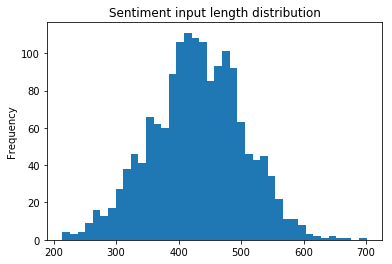

In [54]:
X_train_lengths = list(map(lambda x: len(x.split()), X_train))
df = pd.DataFrame({'counts': X_train_lengths})
df.counts.plot.hist(bins = 40)
plt.title('Sentiment input length distribution')

## Build model 

In [41]:
num_time_steps = 60   # Num of steps in batch (also used for prediction steps into the future)
num_features = 50   # Number of features

In [42]:
print('Build model...')
model = Sequential()
model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index))
model.add(LSTM(128, activation='tanh', dropout=0.3, return_sequences=True)) 
model.add(LSTM(128, activation='tanh', dropout=0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Build model...


In [188]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 50)          20000050  
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 128)         91648     
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_12 (Activation)   (None, 1)                 0         
Total params: 20,223,411
Trainable params: 223,361
Non-trainable params: 20,000,050
_________________________________________________________________


### Setup train and validation input data indicies

In [55]:
maxlen = 500
batch_size = 16
X_train_indices = sentences_to_indices(X_train, word_to_index, maxlen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxlen)

X_all_indices = sentences_to_indices(X_all, word_to_index, maxlen)

print(X_train_indices.shape)
print(X_all_indices.shape)

(1591, 500)
(1807, 500)


### Setup train and validation output data as binary one-hot vectors

In [44]:
nb_classes = 2
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
Y_train = y_train.reshape((-1,1))
Y_test = y_test.reshape((-1,1))

In [56]:
look_back = num_time_steps
X_train_reshape = X_train_indices#create_dataset(X_train_indices, look_back=look_back)
Y_train_reshape = Y_train#Y_train[(look_back-1):]
X_test_reshape = X_test_indices#create_dataset(X_test_indices, look_back=look_back)
Y_test_reshape = Y_test#Y_test[(look_back-1):]

X_all_reshape = X_all_indices

In [57]:
print(X_train_reshape.shape)

(1807, 500)


In [46]:
print('Train...')
history = model.fit(X_train_reshape, Y_train_reshape, batch_size=batch_size, epochs=7,
          validation_data=(X_test_reshape, Y_test_reshape))
model.save("./model.h8")

Train...
Train on 1591 samples, validate on 398 samples
Epoch 1/7
1591/1591 [==============================] - 76s 48ms/step - loss: 0.6839 - accuracy: 0.5783 - val_loss: 0.6885 - val_accuracy: 0.5603
Epoch 2/7
1591/1591 [==============================] - 75s 47ms/step - loss: 0.6795 - accuracy: 0.5845 - val_loss: 0.6874 - val_accuracy: 0.5603
Epoch 3/7
1591/1591 [==============================] - 74s 46ms/step - loss: 0.6776 - accuracy: 0.5833 - val_loss: 0.6884 - val_accuracy: 0.5628
Epoch 4/7
1591/1591 [==============================] - 73s 46ms/step - loss: 0.6749 - accuracy: 0.5845 - val_loss: 0.6894 - val_accuracy: 0.5603
Epoch 5/7
1591/1591 [==============================] - 73s 46ms/step - loss: 0.6817 - accuracy: 0.5858 - val_loss: 0.6855 - val_accuracy: 0.5603
Epoch 6/7
1591/1591 [==============================] - 70s 44ms/step - loss: 0.6757 - accuracy: 0.5858 - val_loss: 0.6912 - val_accuracy: 0.5603
Epoch 7/7
1591/1591 [==============================] - 71s 45ms/step - los

In [61]:
#ADDED BY SASI: SAVE ACTIVATIONS IN LAST LAYER
model2 = Sequential()
model2.add(pretrained_embedding_layer(word_to_vec_map, word_to_index))
model2.add(LSTM(128, activation='tanh', dropout=0.3, return_sequences=True, weights=model.layers[1].get_weights())) 
model2.add(LSTM(128, activation='tanh', dropout=0.3, weights=model.layers[2].get_weights()))
model2.add(Activation('tanh'))

activations = model2.predict(X_all_reshape)


In [63]:
#SAVE ACTIVATIONS for each word (at 56% accuracy) to pass to fx_technical as features

print(activations.shape)
with open('word_acts.p','wb') as f:
    pickle.dump(activations,f)


(1807, 128)


### Print out train and validation accuracy results

In [194]:
score, acc = model.evaluate(X_test_reshape, Y_test_reshape,
                            batch_size=batch_size)
print("Test accuracy: ", acc)
score1, acc1 = model.evaluate(X_train_reshape, Y_train_reshape,
                            batch_size=batch_size)
print("Train accuracy: ", acc1)

398/398 [==============================] - 2s 6ms/step
Test accuracy:  0.5577889680862427
1591/1591 [==============================] - 9s 6ms/step
Train accuracy:  0.6165933609008789


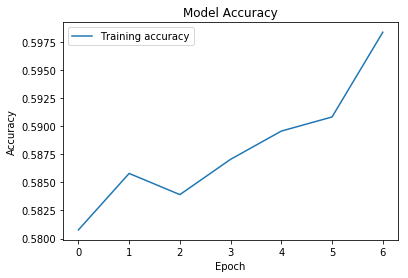

In [195]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Testing accuracy'], loc='best')
plt.show()

In [196]:
y_pred_keras = model.predict(X_test_indices).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [197]:
auc_keras = auc(fpr_keras, tpr_keras)

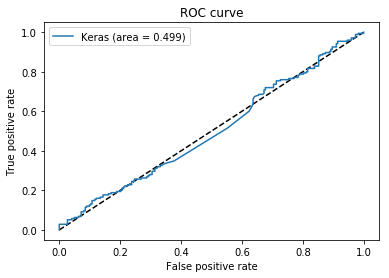

In [198]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()